In [1]:
#importing the required packages
import os,random
import numpy as np
os.environ["KERAS_BACKEND"] = "tensorflow"
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
from keras.utils import np_utils
import keras.models as models
from keras.layers.core import Reshape,Dense,Dropout,Activation,Flatten,Lambda,Permute
from keras.layers.noise import GaussianNoise
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.regularizers import *
from keras.optimizers import Adam
import matplotlib.pyplot as plt
%matplotlib inline
import keras
import pickle, random, time
import _pickle as cPickle

In [2]:
#checking if gpu is available
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.config.list_physical_devices('GPU')

Num GPUs Available:  1


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
#loading the dataset into memory
Xd = pickle.load(open("RML2016.10a_dict.pkl", 'rb'), encoding = 'latin1')
test_snrs,mods = map(lambda j: sorted( list( set( map( lambda x: x[j], Xd.keys() ) ) ) ), [1,0])
X = []
lbl = []

for mod in mods:
    for snr in test_snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
X = np.vstack(X)
print(X.shape)

(220000, 2, 128)


In [4]:
#partitioning the data into test and train data and one-hot encoding the truth values
np.random.seed(2019)
n_examples = X.shape[0]
n_train    = int(round(n_examples * 0.5))
train_idx  = np.random.choice(range(0,n_examples), size=n_train, replace=False)
test_idx   = list(set(range(0,n_examples))-set(train_idx))
X_train    = X[train_idx]
X_test     = X[test_idx]

#function to one-hot encode the truth values
def to_onehot(yy):
    yy1 = np.zeros([len(yy) ,max(yy)+1])
    yy1[  np.arange(len(yy)),yy] = 1 # ?
    return yy1
Y_train = to_onehot(list(map(lambda x: mods.index(lbl[x][0]), train_idx)))
Y_test = to_onehot(list(map(lambda x: mods.index(lbl[x][0]), test_idx)))

in_shp = list(X_train.shape[1:])
print(X_train.shape, in_shp)
classes = mods

(110000, 2, 128) [2, 128]


In [5]:
#building the CNN model explained in the first paper
dr = 0.5 #dropout rate (50%)
cnn = models.Sequential()
cnn.add(Reshape([1]+in_shp, input_shape=in_shp))
cnn.add(ZeroPadding2D((0, 2),data_format='channels_first'))
cnn.add(Convolution2D(256, (1, 3), padding='valid', activation="relu", name="conv1", kernel_initializer='glorot_uniform', data_format='channels_first'))#ch from 3->4
cnn.add(Dropout(dr))
cnn.add(Convolution2D(80, (2, 1), padding='valid', activation="relu", name="conv2", kernel_initializer='glorot_uniform', data_format='channels_first'))
cnn.add(Dropout(dr))
cnn.add(Flatten())
cnn.add(Dense(256, activation='relu', kernel_initializer='he_normal', name="dense1"))
cnn.add(Dropout(dr))
cnn.add(Dense(len(classes), kernel_initializer='he_normal', name="dense2"))
cnn.add(Activation('softmax'))
cnn.add(Reshape([len(classes)]))
cnn.compile(loss='categorical_crossentropy', optimizer='adam')
cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 1, 2, 128)         0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 1, 2, 132)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 256, 2, 130)       1024      
_________________________________________________________________
dropout (Dropout)            (None, 256, 2, 130)       0         
_________________________________________________________________
conv2 (Conv2D)               (None, 80, 1, 130)        41040     
_________________________________________________________________
dropout_1 (Dropout)          (None, 80, 1, 130)        0         
_________________________________________________________________
flatten (Flatten)            (None, 10400)             0

In [6]:
#Defining the linear combination function explained in the second paper
def LC(x):
    import keras.backend as K
    y = K.constant([0, 1, 0, -1, 0, 1],shape=[2,3])
    return K.dot(x,K.transpose(y))

In [7]:
#Building the complex CNN defined in the second paper
complex_CNN = models.Sequential()
complex_CNN.add(Reshape([1]+in_shp, input_shape=in_shp))
complex_CNN.add(ZeroPadding2D((1, 2),data_format='channels_first'))
complex_CNN.add(Convolution2D(256, (2, 3), padding='valid', activation='linear', name="conv1", kernel_initializer='glorot_uniform', data_format='channels_first'))#ch from 3->4
complex_CNN.add(Permute((1,3,2)))
complex_CNN.add(Lambda(LC))
complex_CNN.add(Permute((1,3,2)))
complex_CNN.add(Activation('relu'))
complex_CNN.add(Dropout(dr))
complex_CNN.add(Convolution2D(80, (2, 3), padding='valid', activation="relu", name="conv2", kernel_initializer='glorot_uniform', data_format='channels_first'))
complex_CNN.add(Dropout(dr))
complex_CNN.add(Flatten())
complex_CNN.add(Dense(256, activation='relu', kernel_initializer='he_normal', name="dense1"))
complex_CNN.add(Dropout(dr))
complex_CNN.add(Dense( len(classes), kernel_initializer='he_normal', name="dense2" ))
complex_CNN.add(Activation('softmax'))
complex_CNN.add(Reshape([len(classes)]))
complex_CNN.compile(loss='categorical_crossentropy', optimizer='adam')
complex_CNN.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 1, 2, 128)         0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 1, 4, 132)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 256, 3, 130)       1792      
_________________________________________________________________
permute (Permute)            (None, 256, 130, 3)       0         
_________________________________________________________________
lambda (Lambda)              (None, 256, 130, 2)       0         
_________________________________________________________________
permute_1 (Permute)          (None, 256, 2, 130)       0         
_________________________________________________________________
activation_1 (Activation)    (None, 256, 2, 130)      

In [8]:
# Number of epochs
epochs = 100
# Training batch size
batch_size = 1024  

In [9]:
#Training the first CNN model
start = time.time()
filepath = 'cnn.wts.h5'
history_cnn = cnn.fit(X_train, Y_train, batch_size=batch_size,
    epochs=epochs,
    verbose=2,
    validation_data=(X_test, Y_test),
    callbacks = [
        keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='auto'),
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')
    ])
cnn.load_weights(filepath)
end = time.time()
duration = end - start
print('CNN Training time = ' + str(round(duration/60,5)) + 'minutes')

#Training the second complex CNN model
start = time.time()
filepath = 'complex.wts.h5'
history_complex = complex_CNN.fit(X_train,
    Y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=2,
    validation_data=(X_test, Y_test),
    callbacks = [
        keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='auto'),
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')
    ])
complex_CNN.load_weights(filepath)
end = time.time()
duration = end - start
print('Complex Training time = ' + str(round(duration/60,5)) + 'minutes')

Epoch 1/100
108/108 - 12s - loss: 2.3112 - val_loss: 2.1797
Epoch 2/100
108/108 - 4s - loss: 2.1362 - val_loss: 2.0542
Epoch 3/100
108/108 - 4s - loss: 2.0047 - val_loss: 1.8661
Epoch 4/100
108/108 - 5s - loss: 1.8383 - val_loss: 1.7217
Epoch 5/100
108/108 - 5s - loss: 1.7520 - val_loss: 1.6607
Epoch 6/100
108/108 - 5s - loss: 1.7096 - val_loss: 1.6317
Epoch 7/100
108/108 - 5s - loss: 1.6714 - val_loss: 1.5867
Epoch 8/100
108/108 - 5s - loss: 1.6336 - val_loss: 1.5435
Epoch 9/100
108/108 - 5s - loss: 1.6016 - val_loss: 1.5228
Epoch 10/100
108/108 - 5s - loss: 1.5794 - val_loss: 1.4950
Epoch 11/100
108/108 - 5s - loss: 1.5603 - val_loss: 1.4742
Epoch 12/100
108/108 - 5s - loss: 1.5458 - val_loss: 1.4989
Epoch 13/100
108/108 - 5s - loss: 1.5270 - val_loss: 1.4617
Epoch 14/100
108/108 - 5s - loss: 1.5115 - val_loss: 1.4344
Epoch 15/100
108/108 - 5s - loss: 1.5041 - val_loss: 1.4229
Epoch 16/100
108/108 - 5s - loss: 1.4955 - val_loss: 1.4308
Epoch 17/100
108/108 - 5s - loss: 1.4890 - val_l

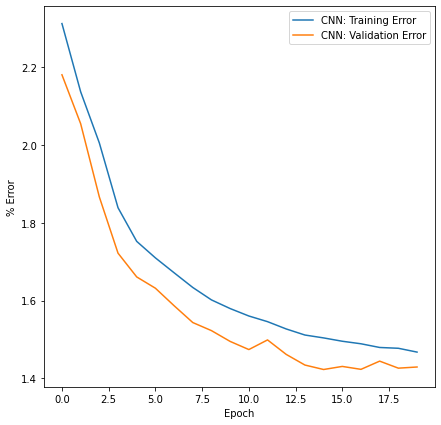

In [10]:
#Plotting the training and validation error for the first CNN
plt.figure(figsize = (7,7))
plt.plot(history_cnn.epoch, history_cnn.history['loss'], label="CNN: Training Error")
plt.plot(history_cnn.epoch, history_cnn.history['val_loss'], label="CNN: Validation Error")
plt.xlabel('Epoch')
plt.ylabel('% Error')
plt.legend()

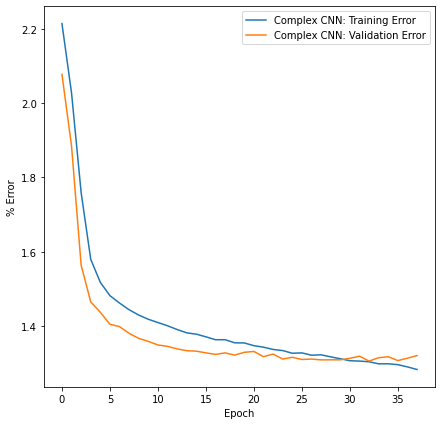

In [21]:
#Plotting the training and validation error for the second complex CNN
plt.figure(figsize = (7,7))
plt.plot(history_complex.epoch, history_complex.history['loss'], label='Complex CNN: Training Error')
plt.plot(history_complex.epoch, history_complex.history['val_loss'], label='Complex CNN: Validation Error')
plt.xlabel('Epoch')
plt.ylabel('% Error')
plt.legend()

In [12]:
#Creating a function to plot the confusion matrices
def plot_confusion_matrix(cm, title='', cmap=plt.cm.Reds, labels=[]):
    my_dpi=96
    plt.figure(figsize=(500/my_dpi, 500/my_dpi), dpi=my_dpi)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar(fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Overall Accuracy - CNN:  0.4678


<Figure size 432x288 with 0 Axes>

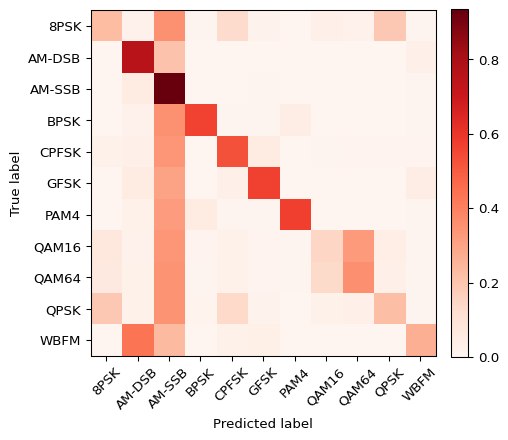

In [13]:
#Plotting the confusion matrix for the first CNN
test_Y_hat = cnn.predict(X_test, batch_size=batch_size)
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])
for i in range(0,X_test.shape[0]):
    j = list(Y_test[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
cor = np.sum(np.diag(conf))
ncor = np.sum(conf) - cor
print("Overall Accuracy - CNN: ", cor / (cor+ncor))
acc = 1.0*cor/(cor+ncor)
plt.figure()
plot_confusion_matrix(confnorm, labels=classes)

Overall Accuracy - Complex:  0.4989363636363636


<Figure size 432x288 with 0 Axes>

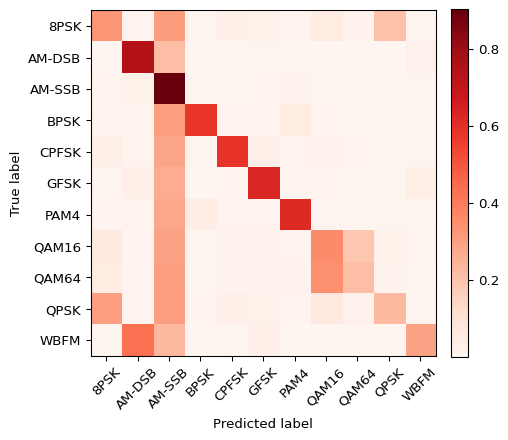

In [14]:
#Plotting the confusion matrix for the second complex CNN
test_Y_hat = complex_CNN.predict(X_test, batch_size=batch_size)
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])
for i in range(0,X_test.shape[0]):
    j = list(Y_test[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
cor = np.sum(np.diag(conf))
ncor = np.sum(conf) - cor
print("Overall Accuracy - Complex: ", cor / (cor+ncor))
acc = 1.0*cor/(cor+ncor)
plt.figure()
plot_confusion_matrix(confnorm, labels=classes)

In [15]:
#Creating one hot labels
labels_oh       = np.eye(11)
samples_db      = np.zeros((20, 11000, 2, 128))
truth_labels_db = np.zeros((20, 11000, 11))

#Pulling out the data by SNR
for i in range(len(test_snrs)):
    for j in range(len(mods)):
        samples_db[i, j*1000:(j+1)*1000,:,:]    = Xd[(mods[j],test_snrs[i])]
        truth_labels_db[i, j*1000:(j+1)*1000,:] = labels_oh[j]

[0.09745455 0.09790909 0.10381818 0.11372727 0.13309091 0.17081818
 0.23481818 0.36918182 0.51690909 0.62618182 0.68754545 0.70181818
 0.71436364 0.70709091 0.71072727 0.70527273 0.70263636 0.71018182
 0.712      0.70227273]


<Figure size 432x288 with 0 Axes>

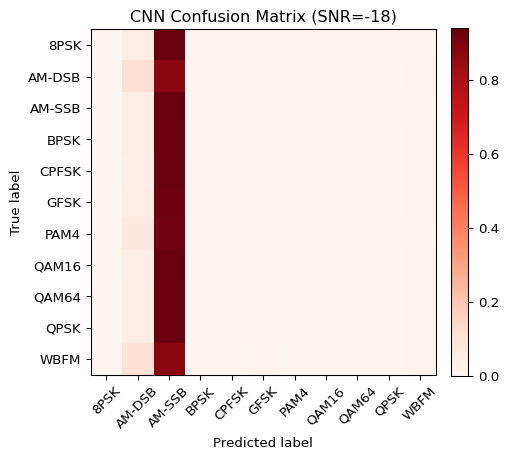

<Figure size 432x288 with 0 Axes>

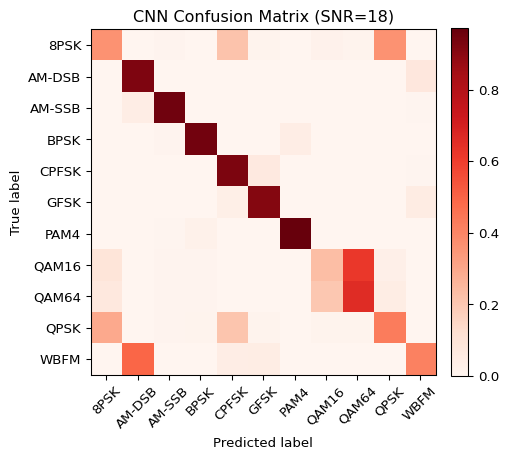

In [18]:
#Plotting confusion matrix for different SNR levels for the first CNN
acc_cnn = np.zeros(len(test_snrs))
for s in range(20):

    test_X_i = samples_db[s]
    test_Y_i = truth_labels_db[s]
    
    test_Y_i_hat = cnn.predict(test_X_i)
    conf = np.zeros([len(mods),len(mods)])
    confnorm = np.zeros([len(mods),len(mods)])
    for i in range(0,test_X_i.shape[0]):
        j = list(test_Y_i[i,:]).index(1)
        k = int(np.argmax(test_Y_i_hat[i,:]))
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(mods)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    #print the confusion matrix @ -18dB and 18dB
    if s == 1 or s == 19:
        plt.figure()
        plot_confusion_matrix(confnorm, labels=classes, title="CNN Confusion Matrix (SNR=%d)"%(test_snrs[s]))
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    acc_cnn[s] = 1.0*cor/(cor+ncor)
print(acc_cnn)

[0.10727273 0.10754545 0.11627273 0.12827273 0.15381818 0.20790909
 0.31481818 0.46772727 0.59972727 0.69727273 0.74127273 0.75127273
 0.764      0.76190909 0.76263636 0.75945455 0.76190909 0.761
 0.76018182 0.75736364]


<Figure size 432x288 with 0 Axes>

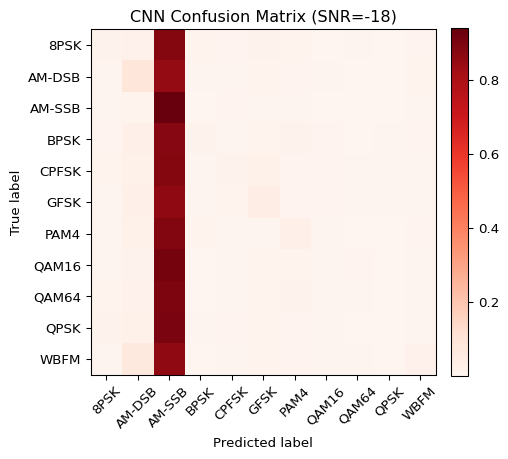

<Figure size 432x288 with 0 Axes>

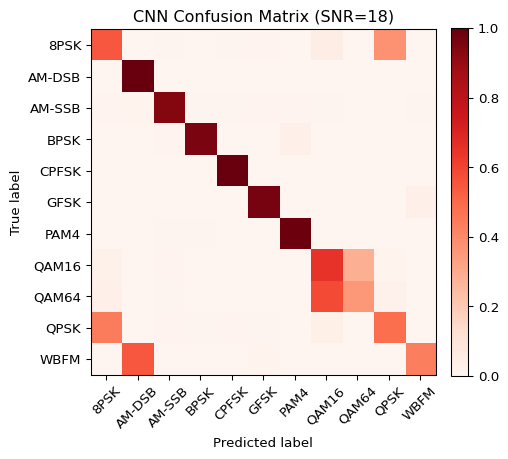

In [19]:
#Plotting confusion matrix for different SNR levels for the second complex CNN
acc_complex = np.zeros(len(test_snrs))
for s in range(20):

    test_X_i = samples_db[s]
    test_Y_i = truth_labels_db[s]
    
    test_Y_i_hat = complex_CNN.predict(test_X_i)
    conf = np.zeros([len(mods),len(mods)])
    confnorm = np.zeros([len(mods),len(mods)])
    for i in range(0,test_X_i.shape[0]):
        j = list(test_Y_i[i,:]).index(1)
        k = int(np.argmax(test_Y_i_hat[i,:]))
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(mods)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    #print the confusion matrix @ -18dB and 18dB
    if s == 1 or s == 19:
        plt.figure()
        plot_confusion_matrix(confnorm, labels=classes, title="CNN Confusion Matrix (SNR=%d)"%(test_snrs[s]))
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    acc_complex[s] = 1.0*cor/(cor+ncor)
print(acc_complex)

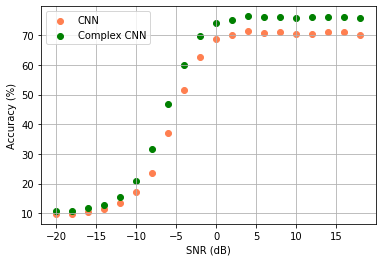

In [20]:
#plotting the classification accuracy with respect to SNR
plt.scatter(range(-20,20,2),acc_cnn*100, label = "CNN", color = 'coral')
plt.scatter(range(-20,20,2),acc_complex*100, label = 'Complex CNN', color = 'green')
plt.grid()
plt.xlabel('SNR (dB)')
plt.ylabel('Accuracy (%)')
plt.legend()